In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import colors

import seaborn as sns
sns.set_style('whitegrid')

In [2]:
!pip install xgboost

In [3]:
class BaselineRegressor:
    """
    Baseline regressor, which calculates the mean value of the target from the training
    data and returns it for each testing sample.
    """
    def __init__(self):
        self.mean = 0

    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        self.mean = np.mean(y_train, axis=0)
        self.classes_count = y_train.shape[1]
        return self

    def predict(self, X_test: np.ndarray):
        return np.full((len(X_test), self.classes_count), self.mean)


class SpectralCurveFiltering():
    """
    Create a histogram (a spectral curve) of a 3D cube, using the merge_function
    to aggregate all pixels within one band. The return array will have
    the shape of [CHANNELS_COUNT]
    """

    def __init__(self, merge_function = np.mean):
        self.merge_function = merge_function

    def __call__(self, sample: np.ndarray):
        return self.merge_function(sample, axis=(1, 2))


In [4]:
from sklearn.decomposition import NMF,FastICA,FactorAnalysis
def load_data(directory: str):
    """Load each cube, reduce its dimensionality and append to array.

    Args:
        directory (str): Directory to either train or test set
    Returns:
        [type]: A list with spectral curve for each sample.
    """
    datalist = []
    masklist = []
    
    all_files = np.array(
        sorted(
            glob(os.path.join(directory, "*.npz")),
            key=lambda x: int(os.path.basename(x).replace(".npz", "")),
        )
    )
    for file_name in all_files:
        with np.load(file_name) as npz:
            mask = npz['mask']
            data=npz['data']
            
            datalist.append(data)
            masklist.append(mask)
    return datalist,masklist
            


def load_gt(file_path: str):
    """Load labels for train set from the ground truth file.
    Args:
        file_path (str): Path to the ground truth .csv file.
    Returns:
        [type]: 2D numpy array with soil properties levels
    """
    gt_file = pd.read_csv(file_path)
    labels = gt_file[["P", "K", "Mg", "pH"]].values/np.array([325.0, 625.0, 400.0, 7.8]) # normalize ground-truth between 0-1
    return labels

In [5]:
cols = ["P2O5", "K", "Mg", "pH"]

In [7]:

raw_data = '/p/project/hai_cons_ee/kuzu/ai4eo-hyperview/hyperview/keras/train_data'
raw_data='/local_home/kuzu_ri/GIT_REPO/ai4eo_hyperview/hyperview/keras/train_data'
train_data = os.path.join(raw_data, 'train_data')
test_data = '/p/project/hai_cons_ee/kuzu/ai4eo-hyperview/hyperview/keras/test_data'

test_data='/local_home/kuzu_ri/GIT_REPO/ai4eo_hyperview/hyperview/keras/test_data'
X_train, M_train = load_data(train_data)
y_train = load_gt(os.path.join(raw_data, "train_gt.csv"))
X_test,M_test = load_data(test_data)

print(f"Train data size: {len(X_train)}")
print(f"Test data size: {len(X_test)}")

Train data size: 1732
Test data size: 1154


In [12]:
X_train[1000].shape

(150, 42, 42)

In [8]:
from tqdm.auto import tqdm
def preprocess(data_list,mask_list):
    
    def _shape_pad(data):
        max_edge = np.max(image.shape[1:])
        shape=(max_edge,max_edge)
        padded=np.pad(data,((0, 0),
                            (0, (shape[0] - data.shape[1])),
                            (0, (shape[1] - data.shape[2]))),
                      'wrap')
        #print(padded.shape)
        return padded
    
    filtering = SpectralCurveFiltering()
    
    processed_data=[]
    
    
    for  idx, (data , mask) in enumerate(tqdm(zip(data_list,mask_list), total=len(data_list), position=0, leave=True,
                   desc="INFO: Preprocessing data ...")):
        
            data=data/2210  ## max-max=5419 mean-max=2210
            m = (1 - mask.astype(int))
            image = (data * m)
            image=_shape_pad(image)
        
            s = np.linalg.svd(image,full_matrices=False,compute_uv=False)
            #s = s /np.expand_dims(np.linalg.norm(s,axis=0),0)
            #f=np.reshape(image,(150,image.shape[-1]*image.shape[-2]))
            #model = NMF(n_components=6, init='random', random_state=0,max_iter=1000)
            #model=FastICA(n_components=6, random_state=0,max_iter=1000, tol=0.01)
            #model=FactorAnalysis(n_components=6, random_state=0)
            #w = model.fit_transform(f)    
            #model = NMF(n_components=3, init='random', random_state=0)
            #W = model.fit_transform(X)

            data = np.ma.MaskedArray(data,mask)
            arr = filtering(data)
            #arr = arr / np.linalg.norm(arr)

            dXdl = np.gradient(arr, axis=0)
            #dXdl = dXdl / np.linalg.norm(dXdl)

            d2Xdl2 = np.gradient(dXdl, axis=0)
            #d2Xdl2 = d2Xdl2 / np.linalg.norm(d2Xdl2)

            fft = np.fft.fft(arr)
            real=np.real(fft)
            #real = real / np.linalg.norm(real)
            imag=np.imag(fft)
            #imag = imag / np.linalg.norm(imag)
            out=np.concatenate([arr,dXdl,d2Xdl2,s[:,0],s[:,1],s[:,2],s[:,3],s[:,4],real,imag],-1)
            processed_data.append(out)
    
    return np.array(processed_data)

X_processed = preprocess(X_train, M_train)

INFO: Preprocessing data ...:   0%|          | 0/1732 [00:00<?, ?it/s]

In [16]:
X_test,M_test = load_data(test_data)
X_test = preprocess(X_test, M_test)

np.save('test.npy',X_test)


INFO: Preprocessing data ...:   0%|          | 0/1154 [00:00<?, ?it/s]

In [260]:
def mixing_augmentation(X,y, fract=0.1):
    #ma_X=np.zeros(shape=X.shape)
    #ma_y=np.zeros(shape=y.shape)

    mix_const=0.05 #np.random.rand(X.shape[0])
    mix_index_1=np.random.randint(X.shape[0], size=int(np.floor(X.shape[0]*fract)))
    mix_index_2=np.random.randint(X.shape[0], size=int(np.floor(X.shape[0]*fract)))
    
    ma_X = (1 - mix_const) * X[mix_index_1] + mix_const * (X[mix_index_2])
    ma_y = (1 - mix_const) * y[mix_index_1] + mix_const * (y[mix_index_2])
    return np.concatenate([X,ma_X],0), np.concatenate([y,ma_y],0)

In [261]:

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.multioutput import MultiOutputRegressor

In [262]:
col_ix = [0,1,2,3]
y_train_col = y_train[:, col_ix] # selected set of labels


In [263]:
kfold = KFold(shuffle=True, random_state=2022)
kfold.get_n_splits(X_train, y_train_col)

5

In [359]:
random_forests = []
baseline_regressors = []

y_hat_bl = []
y_hat_rf = []


for ix_train, ix_valid in kfold.split(np.arange(0,len(y_train))):

    X_t = X_processed[ix_train]
    y_t = y_train_col[ix_train]
    #X_t , y_t = mixing_augmentation(X_t,y_t)
    
    X_v = X_processed[ix_valid]
    y_v = y_train_col[ix_valid]


    # baseline

    baseline = BaselineRegressor()
    baseline.fit(X_t, y_t)

    baseline_regressors.append(baseline)

    # random forest
    #estimators = [('lr', RandomForestRegressor()),('svr', HistGradientBoostingRegressor())]
    #estimators = [
    #('Random Forest', RandomForestRegressor(random_state=42)),
    #('Lasso', LassoCV()),
    #('Gradient Boosting', HistGradientBoostingRegressor(random_state=0))]
    #mu = StackingRegressor(estimators=estimators, final_estimator=SVR())
    rf = RandomForestRegressor(n_estimators=1000,n_jobs=-1,criterion="mse")
    rf.fit(X_t, y_t)
    print(rf.score(X_v, y_v))

    random_forests.append(rf)
    
    # predictions
    
    y_hat = rf.predict(X_v)
    y_b = baseline.predict(X_v)
    
    y_hat_bl.append(y_b)
    y_hat_rf.append(y_hat)

0.11143757049895495
0.15426389082411024
0.15308853082574975
0.15158412209618452
0.14248628833002183


In [360]:
# for now only the last fold

score = 0

for i in range(4):
    print('*'*20, i)
    cons=np.array([325.0, 625.0, 400.0, 7.8])
    mse_rf = mean_squared_error(y_v[:, i]*cons[i], y_hat[:, i]*cons[i])
    mse_bl = mean_squared_error(y_v[:, i]*cons[i], y_b[:, i]*cons[i])
    
    score += mse_rf / mse_bl
    
    print(f'Baseline MSE:      {mse_bl:.2f}')
    print(f'Random Forest MSE: {mse_rf:.2f} ({1e2*(mse_rf - mse_bl)/mse_bl:+.2f} %)')

******************** 0
Baseline MSE:      734.85
Random Forest MSE: 693.90 (-5.57 %)
******************** 1
Baseline MSE:      2962.60
Random Forest MSE: 2359.24 (-20.37 %)
******************** 2
Baseline MSE:      1638.43
Random Forest MSE: 1455.31 (-11.18 %)
******************** 3
Baseline MSE:      0.08
Random Forest MSE: 0.06 (-20.91 %)


In [363]:
print('Evaluation score:', score/4)

Evaluation score: 0.8549267166430683


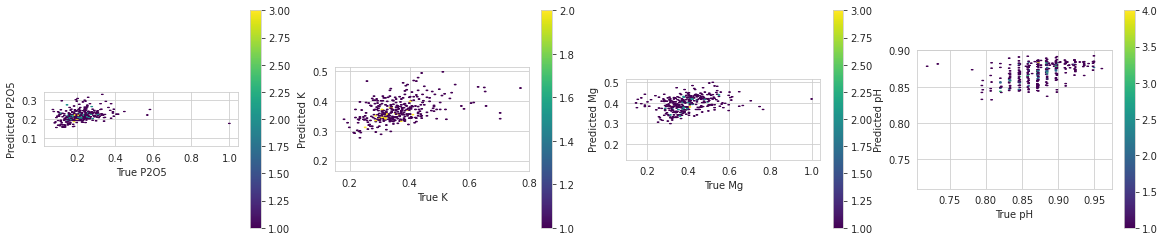

In [364]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

for i, ax in enumerate(axs):
    ax.set_aspect('equal')

    img = ax.hexbin(y_v[:, i], y_hat[:, i], cmap='viridis', mincnt=1)

    ax.plot(np.arange(np.min(y_v[:, i]), np.max(y_v[:, i])),
            np.arange(np.min(y_v[:, i]), np.max(y_v[:, i])), 'r--')

    plt.colorbar(img, ax=ax)

    ax.set_xlabel('True ' + cols[i])
    ax.set_ylabel('Predicted ' + cols[i])

In [334]:
X_test,M_test = load_data(test_data)
X_test = preprocess(X_test, M_test)

predictions = []

for rf in random_forests:
    pp = rf.predict(X_test)
    predictions.append(pp)
    
predictions = np.asarray(predictions)

predictions = np.mean(predictions, axis=0) 
predictions =predictions * np.array([325.0, 625.0, 400.0, 7.8])

submission = pd.DataFrame(data = predictions, columns=["P", "K", "Mg", "pH"])
submission.to_csv("submission.csv", index_label="sample_index")

INFO: Preprocessing data ...:   0%|          | 0/1154 [00:00<?, ?it/s]

In [335]:
submission

,P,K,Mg,pH
0,65.54894,210.6016,147.37326,6.879086
1,67.63378,218.8392,157.62174,6.880922
2,67.37774,224.3422,166.96756,6.860426
3,82.34922,243.6192,171.25670,6.843724
4,73.33680,220.4384,167.89454,6.930604
...,...,...,...,...
1149,52.62702,193.4508,148.01708,6.611358
1150,53.30074,197.4080,145.72954,6.628248
1151,73.05854,234.1664,166.19686,6.614896
1152,55.32660,204.9298,147.60934,6.631888


In [336]:
x=np.array([[1,2,4,3],[4,3,0,6]])
print(x.shape)
a=x/np.expand_dims(np.linalg.norm(x,axis=0),0)

(2, 4)
